In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
tam_dev = pd.read_csv('/content/drive/MyDrive/Sharedtask-offensive_Lang/tamil_dataset/tamil_offensive_full_dev.csv')
display(tam_dev.head())

,Text,Labels
0,Handsome hunk keri vaa thalaivaa,Not_offensive
1,தென்காசி மாவட்டம் நாடார் சமுதாயம் சார்பாக வாழ்...,Not_offensive
2,je vous aime bravo pour clip de merde que j éc...,not-Tamil
3,சிறப்பு..... மேலும் இது போன்ற படைப்புகள் மிக அ...,Not_offensive
4,Vera level BGM .. semma trailer. 🤞,Not_offensive


In [8]:
import pandas as pd

tam_train = pd.read_csv('/content/drive/MyDrive/Sharedtask-offensive_Lang/tamil_dataset/tamil_offensive_full_train.csv')
display(tam_train.head())

,Text,Labels
0,movie vara level la Erika poguthu,Not_offensive
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil
2,Padam nalla comedy padama irukum polaye..,Not_offensive
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive


Test dataset without labels

In [9]:
tam_test = pd.read_csv('/content/drive/MyDrive/Sharedtask-offensive_Lang/tamil_dataset/tamil_offensive_test_without_labels.csv')

In [10]:
print("Train columns:", tam_train.columns)
print("Dev columns:", tam_dev.columns)

print("\nTrain label distribution:")
print(tam_train['Labels'].value_counts())

print("\nDev label distribution:")
print(tam_dev['Labels'].value_counts())

Train columns: Index(['Text', 'Labels'], dtype='object')
Dev columns: Index(['Text', 'Labels'], dtype='object')

Train label distribution:
Labels
Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: count, dtype: int64

Dev label distribution:
Labels
Not_offensive                           3193
Offensive_Untargetede                    356
Offensive_Targeted_Insult_Individual     307
Offensive_Targeted_Insult_Group          295
not-Tamil                                172
Offensive_Targeted_Insult_Other           65
Name: count, dtype: int64


Pre Processing

Noise reduction

Unicode normalization

Emoji & symbol handling

Token normalization

Hashtags, mentions, URLs

In [11]:
!pip install emoji indic-nlp-library -q

In [12]:
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory

# Tamil normalizer
normalizer = IndicNormalizerFactory().get_normalizer("ta")


In [13]:
import re
import emoji

def advanced_kannada_preprocess(text):
    # Step 1: Lowercase (helps uniformity)
    text = str(text).lower()

    # Step 2: Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Step 3: Remove user mentions and hashtags
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"#\w+", '', text)

    # Step 4: Remove emojis and keep their meaning (optional)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r":", ' ', text)  # remove colons around emoji names

    # Step 5: Remove digits and special symbols (retain Kannada + English)
    text = re.sub(r'[^ಀ-೿a-zA-Z\s]', '', text)

    # Step 6: Normalize repeated characters (e.g., “supeerrrr” → “super”)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Step 7: Unicode normalization for Kannada
    text = normalizer.normalize(text)

    # Step 8: Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [14]:
tam_train['clean_text'] = tam_train['Text'].apply(advanced_kannada_preprocess)
tam_dev['clean_text'] = tam_dev['Text'].apply(advanced_kannada_preprocess)
tam_test['clean_text'] = tam_test['Text'].apply(advanced_kannada_preprocess)

# 1. Ensemble **bold text**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all data for consistent vocabulary
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit on train and transform both train/dev/test
X_train_tfidf = tfidf_vectorizer.fit_transform(tam_train['clean_text'])
X_dev_tfidf = tfidf_vectorizer.transform(tam_dev['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(tam_test['clean_text'])

y_train_tfidf = tam_train['Labels']
y_dev_tfidf = tam_dev['Labels']


/tmp/ipython-input-12-1353735212.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Labels', data=tam_train, palette='viridis')


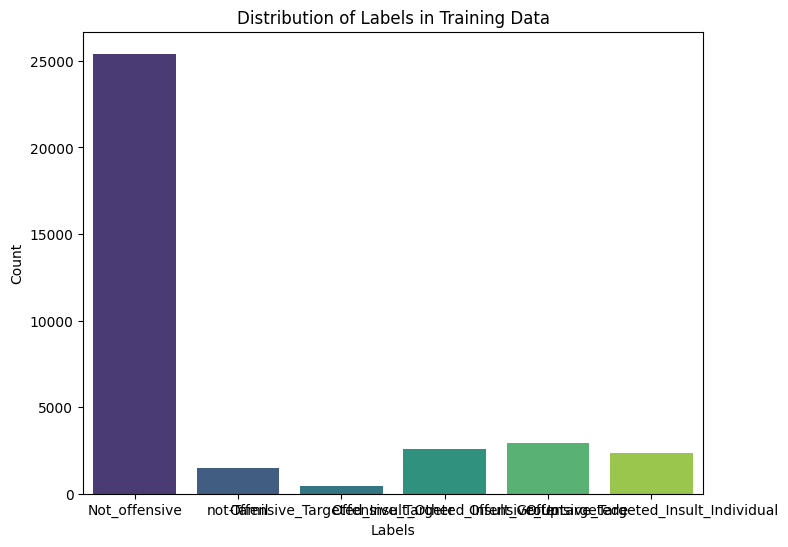

/tmp/ipython-input-12-1353735212.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Labels', data=tam_dev, palette='viridis')


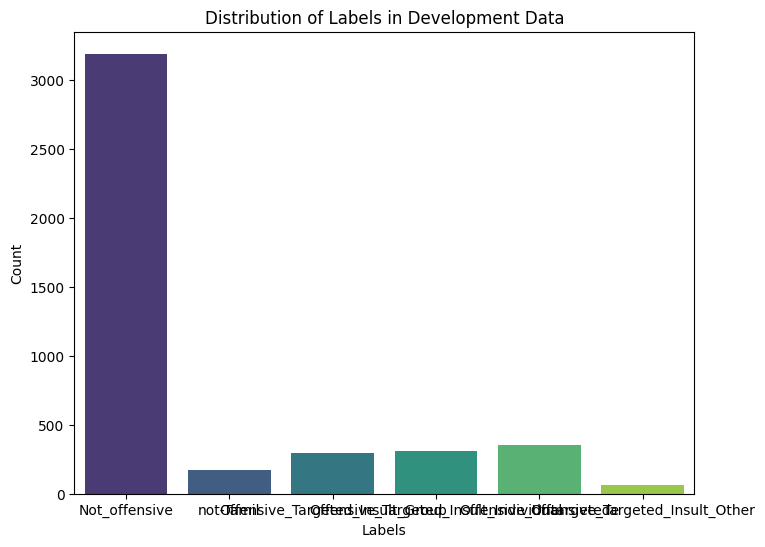

In [ ]:
# prompt: Distribution of labels in the training data provided in the dataset

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution for training data
plt.figure(figsize=(8, 6))
sns.countplot(x='Labels', data=tam_train, palette='viridis')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# Plotting the distribution for development data
plt.figure(figsize=(8, 6))
sns.countplot(x='Labels', data=tam_dev, palette='viridis')
plt.title('Distribution of Labels in Development Data')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_tfidf)
y_dev_enc = le.transform(y_dev_tfidf)


Ensemble Models

 Classifier

In [ ]:
!pip install xgboost -q

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import joblib


clf_lr = LogisticRegression()

clf_xgb = xgb.XGBClassifier(
    max_depth=20, n_estimators=80, learning_rate=0.1,
    colsample_bytree=0.7, gamma=0.1, reg_alpha=4,
    objective='multi:softmax',
    eval_metric='mlogloss'
)

clf_mlp = MLPClassifier(hidden_layer_sizes=(150, 100, 50),
                        max_iter=300, activation='relu',
                        solver='adam', random_state=1)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

clf_svc = SVC(probability=True, kernel='linear')

clf_knn = KNeighborsClassifier(n_neighbors=5)

COMBINING CLASSIFEIER

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', clf_lr),
        ('xgb', clf_xgb),
        ('mlp', clf_mlp),
        ('rf', clf_rf),
        ('svc', clf_svc),
        ('knn', clf_knn)
    ],
    voting='soft'  # or 'soft' if all classifiers support predict_proba
)


Prediction on Dev datasets

In [ ]:
voting_clf.fit(X_train_tfidf, y_train_enc)

y_pred_enc = voting_clf.predict(X_dev_tfidf)
y_pred_VOTING= le.inverse_transform(y_pred_enc)

from sklearn.metrics import classification_report
print(classification_report(y_dev_tfidf, y_pred_VOTING))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                                      precision    recall  f1-score   support

                       Not_offensive       0.78      0.98      0.87      3193
     Offensive_Targeted_Insult_Group       0.38      0.06      0.11       295
Offensive_Targeted_Insult_Individual       0.70      0.12      0.21       307
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00        65
               Offensive_Untargetede       0.51      0.22      0.31       356
                           not-Tamil       0.89      0.60      0.72       172

                            accuracy                           0.77      4388
                           macro avg       0.54      0.33      0.37      4388
                        weighted avg       0.72      0.77      0.71      4388



In [ ]:
y_test_pred_enc = voting_clf.predict(X_test_tfidf)
y_test_pred_labels = le.inverse_transform(y_test_pred_enc)

submission_df = pd.DataFrame({
    'Id': tam_test['ID'],
    'Label': y_test_pred_labels
})
submission_df.to_csv("tamil_TFIDF_ensemble.csv", index=False)


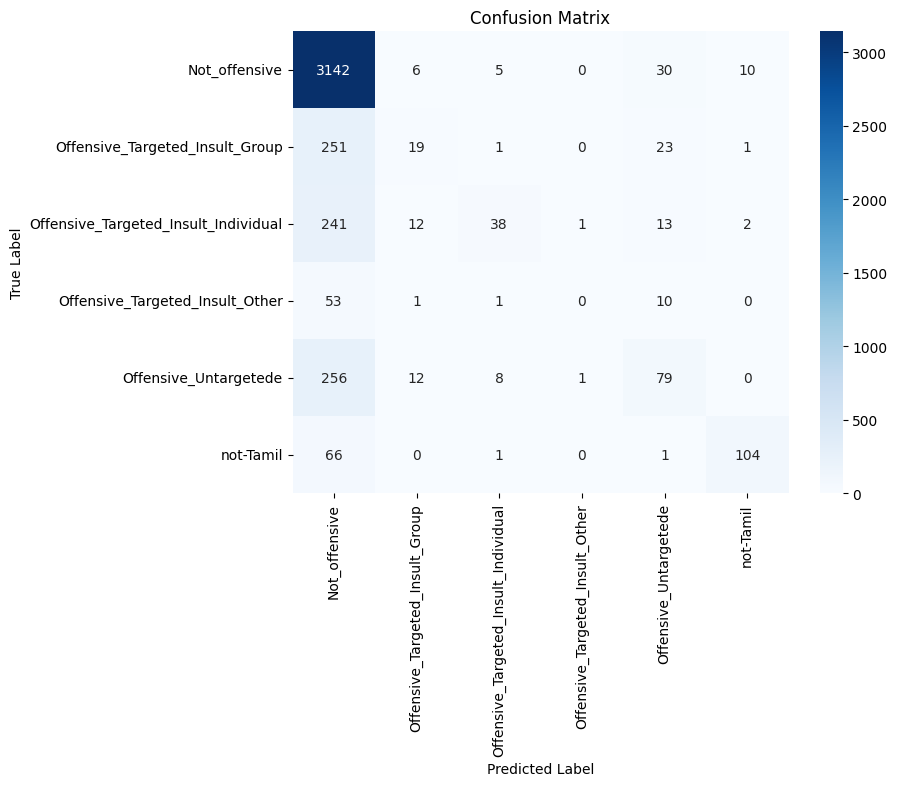

In [ ]:
# prompt: give me  a confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_dev_tfidf, y_pred_VOTING, labels=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

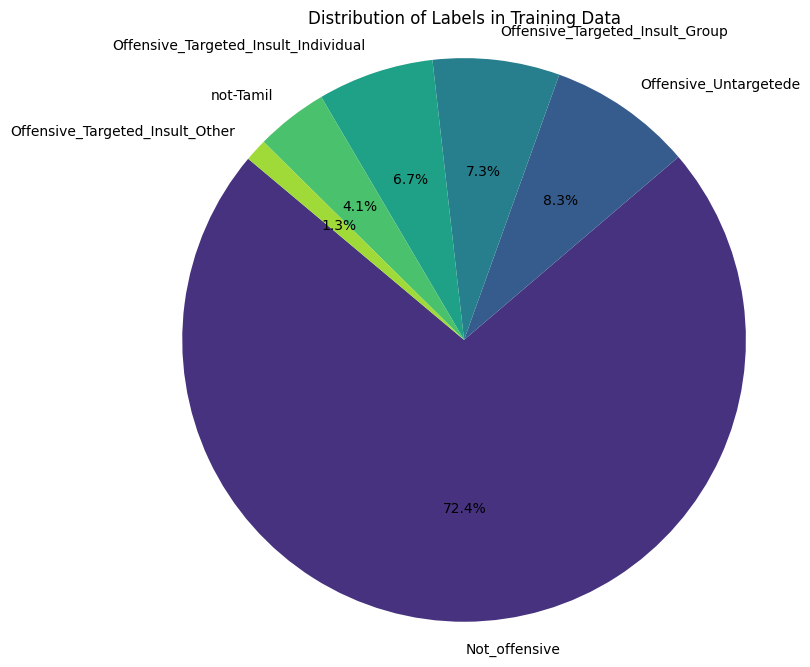

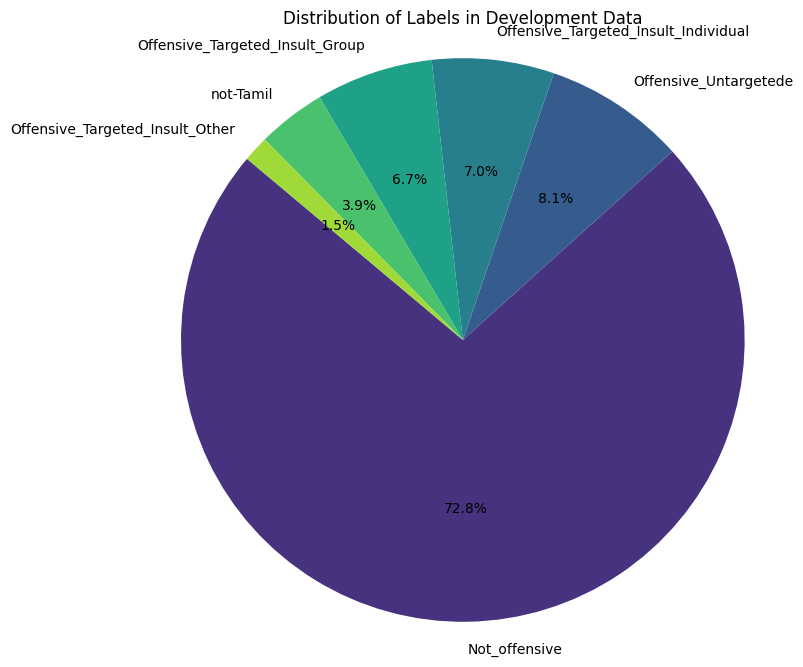

In [ ]:
# prompt: give me a pie chart

import matplotlib.pyplot as plt
# Pie chart for train label distribution
train_labels = tam_train['Labels'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(train_labels, labels=train_labels.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(train_labels)))
plt.title('Distribution of Labels in Training Data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Pie chart for dev label distribution
dev_labels = tam_dev['Labels'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(dev_labels, labels=dev_labels.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(dev_labels)))
plt.title('Distribution of Labels in Development Data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# 2.  FastText + CNN-GRU + TF-IDF Fusion Model


Feature Engineering - tokenizer +TFIDF

Setup — Tokenizer, TF-IDF, and Label Encoder

In [ ]:
!pip install tensorflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

texts_train = tam_train['clean_text'].tolist()
texts_dev = tam_dev['clean_text'].tolist()
labels_train = tam_train['Labels'].tolist()
labels_dev = tam_dev['Labels'].tolist()

# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(labels_train)
y_dev = le.transform(labels_dev)

# Tokenizer for sequence input
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_train)
X_seq_train = tokenizer.texts_to_sequences(texts_train)
X_seq_dev = tokenizer.texts_to_sequences(texts_dev)

max_len = 100
X_seq_train = pad_sequences(X_seq_train, maxlen=max_len, padding='post')
X_seq_dev = pad_sequences(X_seq_dev, maxlen=max_len, padding='post')

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf_train = tfidf.fit_transform(texts_train).toarray()
X_tfidf_dev = tfidf.transform(texts_dev).toarray()


 Load FastText and Build Embedding Matrix

In [ ]:
!pip install fasttext -q
import fasttext
import fasttext.util

# Load tamil FastText
fasttext.util.download_model('ta', if_exists='ignore')
ft_model = fasttext.load_model('cc.ta.300.bin')

# Create embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = ft_model.get_word_vector(word)


 Build Hybrid Fusion Model -FT,TFIDF,

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, GRU,
                                     GlobalMaxPooling1D, Dense, Dropout, Concatenate)

num_classes = len(le.classes_)

# Input 1: FastText Embedding + CNN + GRU
seq_input = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=False)(seq_input)
x = Conv1D(128, 5, activation='relu')(x)
x = GRU(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)

# Input 2: TF-IDF
tfidf_input = Input(shape=(X_tfidf_train.shape[1],))
y = Dense(64, activation='relu')(tfidf_input)

# Fusion
merged = Concatenate()([x, y])
z = Dense(64, activation='relu')(merged)
z = Dropout(0.3)(z)
output = Dense(num_classes, activation='softmax')(z)

model = Model(inputs=[seq_input, tfidf_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
history = model.fit(
    [X_seq_train, X_tfidf_train], y_train,
    epochs=10, batch_size=32,
    validation_data=([X_seq_dev, X_tfidf_dev], y_dev)
)

In [ ]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict([X_seq_dev, X_tfidf_dev])
y_pred = np.argmax(y_pred_probs, axis=1)
y_pred_labels = le.inverse_transform(y_pred)

print(classification_report(labels_dev, y_pred_labels))


In [ ]:
# Assuming the test set has a column named 'Id'
texts_test = tam_test['clean_text'].tolist()

# Step 1: Prepare both input features
# Use the trained Keras Tokenizer and padding
X_seq_test = tokenizer.texts_to_sequences(texts_test)
X_seq_test = pad_sequences(X_seq_test, maxlen=max_len, padding='post')


X_tfidf_test = tfidf.transform(texts_test).toarray()

# Step 2: Predict probabilities → Convert to class index → Decode labels
y_test_pred_probs = model.predict([X_seq_test, X_tfidf_test])
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_labels = le.inverse_transform(y_test_pred)

# Step 3: Prepare final submission format
submission_df = pd.DataFrame({
    'Id': tam_test['ID'],        # Ensure your test data has an 'Id' column
    'labels': y_test_labels
})

#  Step 4: Save as submission CSV
submission_df.to_csv('tam_hybrid_FT_TFIDF_gru_cnn.csv', index=False)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


# IndicBERT + MLPClassifier

In [10]:
from transformers import AutoTokenizer, AutoModel

# Correct model name for IndicBERT
model_IndicBERT = "ai4bharat/indic-bert"

tokenizer = AutoTokenizer.from_pretrained(model_IndicBERT)
model_IndicBERT = AutoModel.from_pretrained(model_IndicBERT)
model_IndicBERT.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(200000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertSdpaAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)
 

In [11]:
# 2. Define Function to Extract CLS Token Embeddings
from tqdm import tqdm
import numpy as np
import torch # Make sure torch is imported

def get_indicbert_cls_embeddings(texts, batch_size=16, max_length=128):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenize and convert to tensors
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

        with torch.no_grad():
            # Explicitly pass the input tensors
            outputs = model_IndicBERT(input_ids=inputs['input_ids'],
                                      attention_mask=inputs['attention_mask'])
            # Add token_type_ids if present in inputs and required by the model
            if 'token_type_ids' in inputs and hasattr(model_IndicBERT, 'token_type_ids'):
                 outputs = model_IndicBERT(input_ids=inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'],
                                           token_type_ids=inputs['token_type_ids'])
            else:
                 outputs = model_IndicBERT(input_ids=inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'])


        # Get [CLS] token embeddings (first token)
        cls_embeds = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, 768)
        all_embeddings.append(cls_embeds.cpu().numpy())

    return np.vstack(all_embeddings)

In [12]:
# 3. Prepare Train / Dev / Test Datasets
# Assuming you already preprocessed the text using `advanced_kannada_preprocess`

texts_train = tam_train['clean_text'].tolist()
texts_dev = tam_dev['clean_text'].tolist()
texts_test = tam_test['clean_text'].tolist()

labels_train = tam_train['Labels'].tolist()
labels_dev = tam_dev['Labels'].tolist()


In [13]:
# 4. Extract IndicBERT CLS Embeddings
X_train_ib = get_indicbert_cls_embeddings(texts_train)
X_dev_ib = get_indicbert_cls_embeddings(texts_dev)
X_test_ib = get_indicbert_cls_embeddings(texts_test)  # Test set has no labels


  0%|          | 0/2197 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

100%|██████████| 275/275 [12:28<00:00,  2.72s/it]


In [14]:
# 5. Encode Labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(labels_train)
y_dev_enc = le.transform(labels_dev)



In [15]:
#  6. Train MLPClassifier on IndicBERT embeddings
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

mlp.fit(X_train_ib, y_train_enc)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)

In [16]:
# 7. Evaluate on Dev Set
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Re-fit the LabelEncoder within this cell to ensure it's fitted before inverse_transform
le = LabelEncoder()
le.fit(labels_dev) # Fit on dev labels to ensure all possible labels for inverse_transform are covered

y_pred_dev = mlp.predict(X_dev_ib)
y_pred_dev_labels = le.inverse_transform(y_pred_dev)

print(classification_report(labels_dev, y_pred_dev_labels))

                                      precision    recall  f1-score   support

                       Not_offensive       0.76      0.96      0.85      3193
     Offensive_Targeted_Insult_Group       0.32      0.05      0.09       295
Offensive_Targeted_Insult_Individual       0.33      0.08      0.13       307
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00        65
               Offensive_Untargetede       0.28      0.08      0.13       356
                           not-Tamil       0.66      0.58      0.62       172

                            accuracy                           0.74      4388
                           macro avg       0.39      0.29      0.30      4388
                        weighted avg       0.65      0.74      0.67      4388



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# 8. Predict on Test Set (Without Labels)
y_test_pred = mlp.predict(X_test_ib)
y_test_labels = le.inverse_transform(y_test_pred)

# Create submission DataFrame with ID and Label
submission_df = pd.DataFrame({
    'Id': tam_test['ID'],               # Make sure this column exists in your test CSV
    'labels': y_test_labels
})

# Save to CSV
submission_df.to_csv("Tamil_IndicBERT_MLP_submission.csv", index=False)


In [21]:
import joblib

# Save the trained model to a file
# Corrected the path to save to an existing or easily creatable directory
joblib.dump(mlp, '/content/drive/MyDrive/Sharedtask-offensive_Lang/Tamil_Results/tamil_indicbert_mlp_model.pkl')

['/content/drive/MyDrive/Sharedtask-offensive_Lang/Tamil_Results/tamil_indicbert_mlp_model.pkl']

In [23]:
mlp_loaded = joblib.load('/content/drive/MyDrive/Sharedtask-offensive_Lang/Tamil_Results/tamil_indicbert_mlp_model.pkl')

In [24]:
# Predict using the loaded model
y_pred_dev = mlp_loaded.predict(X_dev_ib)
y_pred_labels = le.inverse_transform(y_pred_dev)

# Evaluate
print(classification_report(labels_dev, y_pred_labels))


                                      precision    recall  f1-score   support

                       Not_offensive       0.76      0.96      0.85      3193
     Offensive_Targeted_Insult_Group       0.32      0.05      0.09       295
Offensive_Targeted_Insult_Individual       0.33      0.08      0.13       307
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00        65
               Offensive_Untargetede       0.28      0.08      0.13       356
                           not-Tamil       0.66      0.58      0.62       172

                            accuracy                           0.74      4388
                           macro avg       0.39      0.29      0.30      4388
                        weighted avg       0.65      0.74      0.67      4388



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 2. XLM-Roberta (XLM-R)

What You'll Do
✔ Use xlm-roberta-base from HuggingFace 🤗
✔ Extract CLS-token embeddings from text
✔ Train a classifier (like Logistic Regression) on those embeddings
✔ Evaluate on dev set

In [1]:
!pip install transformers -q
!pip install torch -q

**Step 2: Load XLM-R Tokenizer and Model**
# MODEL 1= xlm-roberta-base

Why XLM-R?
Trained on 100+ languages (including Kannada, Tamil, Malayalam)
Context-aware, handles code-mixed and low-resource texts well

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pretrained tokenizer and model
model_xlm_roberta = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_xlm_roberta)
model = AutoModel.from_pretrained(model_xlm_roberta)
model.eval()  # Set to eval mode, since we are not fine-tuning


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine

# Feature Extraction Function (CLS Token)- XLM-Roberta

 Whats happening here?
  Tokenizes and batches the text
  Passes through XLM-R to get last hidden state
  Extracts CLS  token as sentence embedding

In [3]:
!pip install transformers -q
!pip install torch -q

**Step 2: Load XLM-R Tokenizer and Model**
# MODEL 1= xlm-roberta-base

Why XLM-R?
Trained on 100+ languages (including Kannada, Tamil, Malayalam)
Context-aware, handles code-mixed and low-resource texts well

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pretrained tokenizer and model
model_xlm_roberta = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_xlm_roberta)
model = AutoModel.from_pretrained(model_xlm_roberta)
model.eval()  # Set to eval mode, since we are not fine-tuning


XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine

# Feature Extraction Function (CLS Token)- XLM-Roberta

 Whats happening here?
  Tokenizes and batches the text
  Passes through XLM-R to get last hidden state
  Extracts CLS  token as sentence embedding

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

# Load pretrained tokenizer and model (duplicated from ZG9Q6yfp2wKZ to ensure correct objects are used)
model_xlm_roberta = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_xlm_roberta)
model = AutoModel.from_pretrained(model_xlm_roberta)
model.eval()  # Set to eval mode


# Define Feature Extraction Function (CLS Token)- XLM-Roberta (duplicated from q5ECe_xa2-Ji)
def get_xlm_cls_embeddings(texts, batch_size=16, max_length=128):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

        with torch.no_grad():
            # Explicitly pass the input tensors
            outputs = model(input_ids=inputs['input_ids'],
                            attention_mask=inputs['attention_mask'])
            # Add token_type_ids if present and required by the model
            if 'token_type_ids' in inputs and hasattr(model, 'token_type_ids'):
                 outputs = model(input_ids=inputs['input_ids'],
                                 attention_mask=inputs['attention_mask'],
                                 token_type_ids=inputs['token_type_ids'])
            else:
                 outputs = model(input_ids=inputs['input_ids'],
                                 attention_mask=inputs['attention_mask'])


        # CLS token: first token in the sequence
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # (batch_size, hidden_size)
        all_embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)


# Extract XLM-R CLS Embeddings
X_train_xlm = get_xlm_cls_embeddings(tam_train['clean_text'].tolist())
X_dev_xlm = get_xlm_cls_embeddings(tam_dev['clean_text'].tolist())

y_train_xlm= tam_train['Label']
y_dev_xlm =tam_dev['Label']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

NameError: name 'tam_train' is not defined

In [ ]:
X_test_xlm = get_xlm_cls_embeddings(tam_test['clean_text'].tolist())

# #HYBRID MODEL **XLM-RoBERTa + XGBoost + Class Balancing (Ensemble Logic)**

In [ ]:
!pip install xgboost -q

import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

Step 2: Encode Labels

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_xlm)
y_dev_enc = le.transform(y_dev_xlm)

# Optional: view label mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

3. Step 3: Handle Class Imbalance

In [ ]:
# Compute class distribution
(unique, counts) = np.unique(y_train_enc, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

# Compute class weights inversely proportional to frequency
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_enc),
                                     y=y_train_enc)
print("Class Weights:", class_weights)


Step 4: Train XGBoost with Class Weighting

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.9,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=1  # Optional: tune or ignore for multi-class
)

xgb_model.fit(X_train_xlm, y_train_enc)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:27:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=4, ...)

 Step 5: Predict & Evaluate

In [ ]:
y_pred_enc = xgb_model.predict(X_dev_xlm)
y_pred = le.inverse_transform(y_pred_enc)

print(classification_report(y_dev_xlm, y_pred))


                      precision    recall  f1-score   support

       not offensive       0.71      0.92      0.80       270
            not tulu       0.84      0.64      0.73       156
  offensive targeted       0.88      0.44      0.59        52
offensive untargeted       0.89      0.73      0.80        99

            accuracy                           0.77       577
           macro avg       0.83      0.68      0.73       577
        weighted avg       0.79      0.77      0.76       577



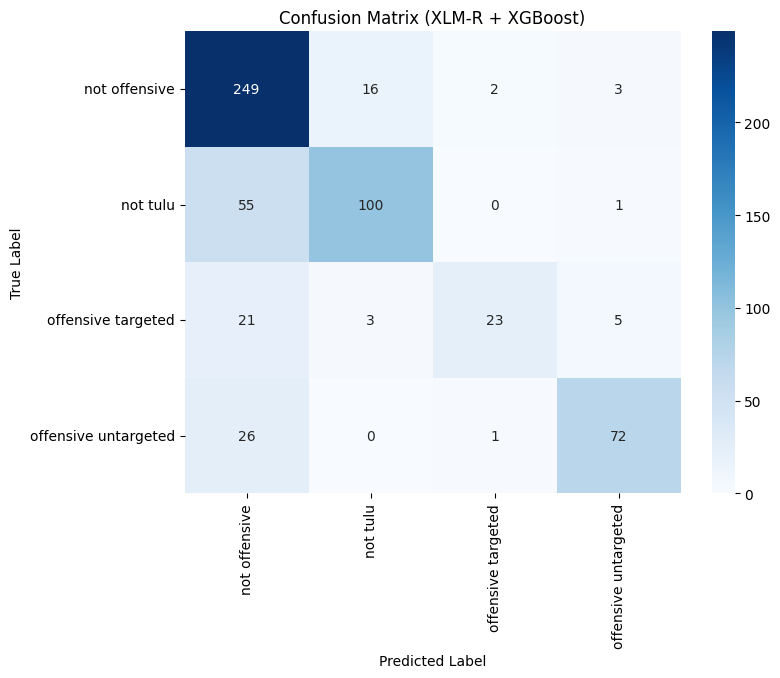

In [ ]:
# prompt: generate the TP,FP,etc confusion MAtrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure le is fitted on the combined set of all possible labels
# This is important for the confusion matrix tick labels to include all classes
all_labels = pd.concat([y_train_xlm, y_dev_xlm]).unique()
le.fit(all_labels)

# Generate the confusion matrix
cm = confusion_matrix(y_dev_xlm, y_pred, labels=le.classes_)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (XLM-R + XGBoost)')
plt.show()

In [18]:
# Step 1: Get XLM-R CLS embeddings for test data
X_test_without_labels = get_xlm_cls_embeddings(tam_test['clean_text'].tolist())

# Step 2: Predict using XGBoost model
y_test_pred_without_labels = xgb_model.predict(X_test_without_labels)

# Step 3: Decode predicted class indices to original labels
y_test_pred_labels = le.inverse_transform(y_test_pred_without_labels)

# Step 4: Create submission DataFrame with only ID and predicted label
submission_df = pd.DataFrame({
    'Id': tam_test['ID'],  #  Corrected column name from 'Id' to 'ID'
    'labels': y_test_pred_labels
})

# Step 5: Save the submission CSV
submission_df.to_csv("tam_XLMR_XGB_submission.csv", index=False)

NameError: name 'get_xlm_cls_embeddings' is not defined

In [ ]:
# Step 5: Save the submission CSV
submission_df.to_csv("tam_XLMR_XGB_submission.csv", index=False)

In [ ]:
xgb_model.save_model("/content/drive/MyDrive/Sharedtask-offensive_Lang/Tamil_Results/models/tamil_xgb_model_xlmr.json")


In [ ]:
xgb_model_loaded = xgb.XGBClassifier()
xgb_model_loaded.load_model("/content/drive/MyDrive/Sharedtask-offensive_Lang/Tamil_Results/models/tamil_xgb_model_xlmr.json")


In [ ]:
le = joblib.load("label_encoder_tam_xlmr.pkl")

In [ ]:
import joblib

# Save label encoder
joblib.dump(le, "/content/drive/MyDrive/Sharedtask-offensive_Lang/Tamil_Results/models/label_encoder_tam_xlmr.pkl")


model comparision

In [ ]:
# prompt: generate the analysis

print("\nAnalysis Report")
print("---------------")

# Print Classification Report for Voting Classifier
print("\nClassification Report for Voting Classifier (TF-IDF Features) on Dev Set:")
print(classification_report(y_dev_tfidf, y_pred_VOTING))

# Print Classification Report for Hybrid (FT+TF-IDF+CNN-GRU) Model
print("\nClassification Report for Hybrid (FastText + TF-IDF + CNN-GRU) Model on Dev Set:")
print(classification_report(labels_dev, y_pred_labels))

# Print Classification Report for IndicBERT + MLP
print("\nClassification Report for IndicBERT + MLPClassifier on Dev Set:")
print(classification_report(labels_dev, y_pred_dev_labels))

# Print Classification Report for XLM-RoBERTa + XGBoost
print("\nClassification Report for XLM-RoBERTa + XGBoost on Dev Set:")
print(classification_report(y_dev_xlm, y_pred))

print("\nSummary of Submissions Generated:")
print("- TULU_TFIDF_Ensemble_submission.csv (from Voting Classifier on TF-IDF)")
print("- tulu_hybrid_FT_TFIDF_gru_cnn.csv (from Hybrid FastText + TF-IDF + CNN-GRU)")
print("- TULU_test_IndicBERT_MLP_submission.csv (from IndicBERT + MLPClassifier)")
print("- (Prediction for XLM-RoBERTa + XGBoost is ready but not saved to a specific file yet)")

print("\nVisualizations Generated:")
print("- Count plots for Train and Dev label distributions.")
print("- Pie charts for Train and Dev label distributions.")
print("- Confusion Matrix for Voting Classifier (TF-IDF) on Dev Set.")

print("\nNote: For final submission, review the performance metrics and select the best performing model based on your criteria.")



Analysis Report
---------------

Classification Report for Voting Classifier (TF-IDF Features) on Dev Set:
                      precision    recall  f1-score   support

       not offensive       0.74      0.91      0.82       270
            not tulu       0.82      0.68      0.74       156
  offensive targeted       0.88      0.44      0.59        52
offensive untargeted       0.87      0.76      0.81        99

            accuracy                           0.78       577
           macro avg       0.83      0.70      0.74       577
        weighted avg       0.80      0.78      0.77       577


Classification Report for Hybrid (FastText + TF-IDF + CNN-GRU) Model on Dev Set:
                      precision    recall  f1-score   support

       not offensive       0.84      0.84      0.84       270
            not tulu       0.79      0.80      0.79       156
  offensive targeted       0.71      0.65      0.68        52
offensive untargeted       0.83      0.84      0.83        99


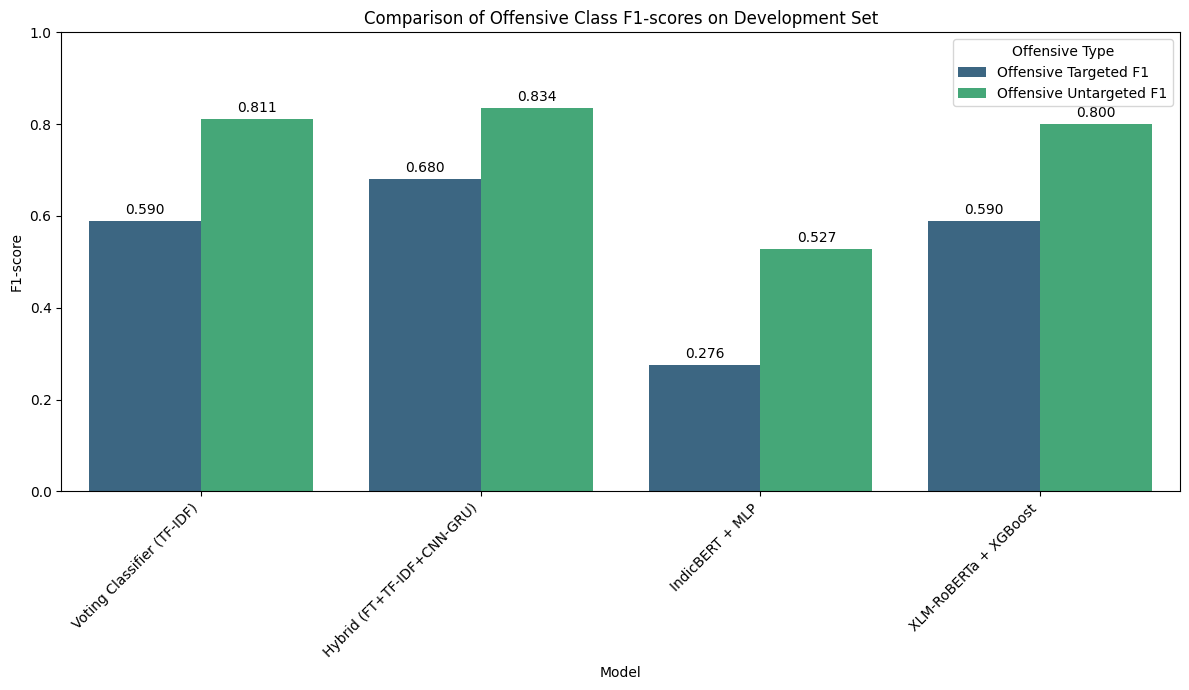

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from io import StringIO

# Assuming the classification reports were printed in the previous cell (BGRGUh-oIswy)
# We need to re-run the previous cell or capture its output to get the reports as strings
# For now, I'll assume the reports are available as strings or need to be regenerated.
# A robust way is to capture the output of the previous cell or regenerate the reports.

# --- Regenerate Classification Reports to capture them as strings ---
from sklearn.metrics import classification_report

# Capture reports as strings
report_voting = classification_report(y_dev_tfidf, y_pred_VOTING, output_dict=True)
report_hybrid = classification_report(labels_dev, y_pred_labels, output_dict=True)
report_indicbert = classification_report(labels_dev, y_pred_dev_labels, output_dict=True)
report_xlmr = classification_report(y_dev_xlm, y_pred, output_dict=True)


# --- Extract F1-scores for offensive classes ---
models = ['Voting Classifier (TF-IDF)', 'Hybrid (FT+TF-IDF+CNN-GRU)', 'IndicBERT + MLP', 'XLM-RoBERTa + XGBoost']
offensive_targeted_f1 = [
    report_voting['offensive targeted']['f1-score'],
    report_hybrid['offensive targeted']['f1-score'],
    report_indicbert['offensive targeted']['f1-score'],
    report_xlmr['offensive targeted']['f1-score']
]

offensive_untargeted_f1 = [
    report_voting['offensive untargeted']['f1-score'],
    report_hybrid['offensive untargeted']['f1-score'],
    report_indicbert['offensive untargeted']['f1-score'],
    report_xlmr['offensive untargeted']['f1-score']
]

# Create a DataFrame for easier plotting
f1_df = pd.DataFrame({
    'Model': models,
    'Offensive Targeted F1': offensive_targeted_f1,
    'Offensive Untargeted F1': offensive_untargeted_f1
})

# Reshape for seaborn.barplot
f1_df_melted = f1_df.melt(id_vars='Model', var_name='Offensive Type', value_name='F1-score')


# --- Generate the bar chart ---
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='Model', y='F1-score', hue='Offensive Type', data=f1_df_melted, palette='viridis')

plt.ylim(0, 1)  # F1 score is between 0 and 1
plt.title('Comparison of Offensive Class F1-scores on Development Set')
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add F1 scores on top of the bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.3f', label_type='edge', padding=3)

plt.show()

In [6]:
import pandas as pd
from scipy.stats import mode # Although imported, this will not be used in the corrected code

# Load the CSVs
df_tfidf_ensemble = pd.read_csv("/content/drive/MyDrive/Sharedtask-offensive_Lang/Tamil_Results/tamil_TFIDF_ensemble.csv")
df_indicbert_mlp = pd.read_csv("/content/drive/MyDrive/Sharedtask-offensive_Lang/Tamil_Results/Tamil_IndicBERT_MLP_submission.csv")

# Merge all predictions by 'ID'
merged_df = df_tfidf_ensemble[['Id']].copy()
merged_df['tfidf_ensemble'] = df_tfidf_ensemble['Label']
merged_df['indicbert_mlp'] = df_indicbert_mlp['labels']

# Perform majority (hard) voting using pandas mode
# The pandas mode() method can handle non-numeric data
voted_labels = merged_df[['tfidf_ensemble', 'indicbert_mlp']].mode(axis=1)[0]


# Add the final predicted labels
merged_df['labels'] = voted_labels

# Final submission format
submission_df = merged_df[['Id', 'labels']]

# Save to CSV
submission_df.to_csv("Tamil_FINAL_VOTING_SUBMISSION.csv", index=False)
print("Submission file saved as Tamil_FINAL_VOTING_SUBMISSION.csv")

Submission file saved as Tamil_FINAL_VOTING_SUBMISSION.csv


In [8]:
import pandas as pd
from scipy.stats import mode # Although imported, this will not be used in the corrected code

# Load the CSVs
df_tfidf_ensemble = pd.read_csv("/content/mal_TFIDF_Ensemble_submission (1).csv")
df_indicbert_mlp = pd.read_csv("/content/mal_test_IndicBERT_MLP_submission (1).csv")

# Merge all predictions by 'ID'
merged_df = df_tfidf_ensemble[['Id']].copy()
merged_df['tfidf_ensemble'] = df_tfidf_ensemble['labels']
merged_df['indicbert_mlp'] = df_indicbert_mlp['labels']

# Perform majority (hard) voting using pandas mode
# The pandas mode() method can handle non-numeric data
voted_labels = merged_df[['tfidf_ensemble', 'indicbert_mlp']].mode(axis=1)[0]


# Add the final predicted labels
merged_df['labels'] = voted_labels

# Final submission format
submission_df = merged_df[['Id', 'labels']]

# Save to CSV
submission_df.to_csv("MAL_FINAL_VOTING_SUBMISSION.csv", index=False)
print("Submission file saved as MAL_FINAL_VOTING_SUBMISSION.csv")

Submission file saved as MAL_FINAL_VOTING_SUBMISSION.csv
